In [2]:
import warnings
import sys, os, cv2, glob, json, gc
import multiprocessing
from multiprocessing import Pool

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from moviepy.editor import VideoFileClip
import skvideo.io

import pandas as pd
import numpy as np
import circstat as CS
import scipy as sc
import math, random

import itertools
from itertools import chain
from tqdm import tqdm


from processing import *
from kinematics import *
from skeleton import *

warnings.filterwarnings("ignore")

os.makedirs('./data',exist_ok=True)
os.makedirs('./utils',exist_ok=True)

#download custom processing scripts if not already downloaded
# !wget -P . https://raw.githubusercontent.com/quietscientist/gma_score_prediction_from_video/refs/heads/main/utils/kinematics.py
# !wget -P . https://raw.githubusercontent.com/quietscientist/gma_score_prediction_from_video/refs/heads/main/utils/circstat.py
# !wget -P . https://raw.githubusercontent.com/quietscientist/gma_score_prediction_from_video/refs/heads/main/utils/processing.py
# !wget -P . https://raw.githubusercontent.com/quietscientist/gma_score_prediction_from_video/refs/heads/main/utils/skeleton.py

#download example data or upload your own json annotations

#--------------------------------------------------------------------------------------
# Download example raw data from figshare or specify path to your own json annotations |
#--------------------------------------------------------------------------------------

#!wget -P . https://figshare.com/ndownloader/articles/25316500/versions/1
# #unzip data into ./data folder and remove zip file
# !unzip ./1 -d ./data
# !rm ./1

In [4]:
#uncomment install if running on google colab
#%pip install scikit-video
DEIDENTIFY = True #set to True to deidentify data, and exclude xy coordinates and pixel values from output
OVERWRITE = True
USE_CENTER_INSTANCE = False
USE_BEST_INSTANCE = True

dataset = 'gma_score_prediction'
json_path = f'./data/Infant Pose Data/{dataset}/annotations'
json_files = os.listdir(json_path)
directory = f'./data'

save_path = f'./pose_estimates/{dataset}_pose_estimates'

os.makedirs(save_path, exist_ok=True)

kp_mapping = {0:'Nose', 1:'Neck', 2:'RShoulder', 3:'RElbow', 4:'RWrist', 5:'LShoulder', 6:'LElbow',
              7:'LWrist', 8:'RHip', 9:'RKnee', 10:'RAnkle', 11:'LHip',
              12:'LKnee', 13:'LAnkle', 14:'REye', 15:'LEye', 16:'REar', 17:'LEar'}

# Define the DataFrame columns as specified
columns = ['video_number', 'video', 'bp', 'frame', 'x', 'y', 'c','fps', 'pixel_x', 'pixel_y', 'time', 'part_idx']
data = []  # This will hold the data to be loaded into the DataFrame

vid_info = pd.read_csv(f'./data/{dataset}_video_info.csv')

In [6]:
# format files as pkl with openpose standard and bodypart labels

def process_file(args):
    """Function to process a single file."""
    file_number, file, json_path, save_path, vid_info, kp_mapping = args
    # Construct the full file path
    file_path = os.path.join(json_path, file)
    fname = file.split('.')[0]
    interim = []

    if not OVERWRITE and os.path.exists(f'{save_path}/{fname}.pkl'):
        return

    # Open and load the JSON data
    try: 
        with open(file_path, 'r') as f:
            frames = json.load(f)
            info = vid_info[vid_info['video'] == fname]
            fps = vid_info['fps'].values[0]

            pixel_x = vid_info['width'].values[0]
            pixel_y = vid_info['height'].values[0]
            
            center_x = pixel_x / 2
            center_y = pixel_y / 2
            
            # Iterate through each frame in the JSON file
            for frame in frames:
                frame_id = frame['frame_id']
                if 'instances' in frame and len(frame['instances']) > 0:

                    if USE_CENTER_INSTANCE:
                        instance_id = get_center_instance(frame['instances'], center_x, center_y)
                    elif USE_BEST_INSTANCE:
                        instance_id = get_best_instance(frame['instances'])
                    else:
                        instance_id = 0

                    keypoints = frame['instances'][instance_id]['keypoints']
                    confidence = frame['instances'][instance_id]['keypoint_scores']
                    keypoints, confidence = convert_coco_to_openpose(keypoints, confidence)

                    # Iterate through each keypoint
                    for part_idx, (x, y) in enumerate(keypoints):

                        bp = kp_mapping[part_idx]
                        fps = fps
                        time = frame_id / fps
                        c = confidence[part_idx]

                        row = [file_number, fname, bp, frame_id, x, y, c, fps, pixel_x, pixel_y, time, part_idx]
                        interim.append(row)

        interim_df = pd.DataFrame(interim, columns=columns)
        interim_df.to_csv(f'{save_path}/{fname}.csv', index=False)

        del interim_df
        return
    
    except Exception as e:
        return
    
def process_annotations_multiprocess(json_files, json_path, save_path, vid_info, kp_mapping):
    """Run the annotation processing using multiprocessing."""
    args = [
        (file_number, file, json_path, save_path, vid_info, kp_mapping)
        for file_number, file in enumerate(json_files)
    ]

    # Set up a pool of workers
    with Pool(processes=20) as pool:
        pool.map(process_file, args)


In [7]:
process_annotations_multiprocess(json_files, json_path, save_path, vid_info, kp_mapping)

In [8]:
# Ensure the save_path directory exists
save_path = f'./pose_estimates/{dataset}_norm'

if os.path.exists(f'{save_path}/pose_estimates_{dataset}.csv'):
    os.remove(f'{save_path}/pose_estimates_{dataset}.csv')
    print('Removed existing CSV file')

for pklfile in tqdm(os.listdir(save_path)):
    if not pklfile.endswith('.pkl'):
        continue
    else:
        interim_df = pd.read_pickle(f'{save_path}/{pklfile}')
        interim_df.to_csv(f'{save_path}/pose_estimates_{dataset}.csv', mode='a', header=False, index=False)

    del interim_df

Removed existing CSV file


100%|██████████| 1068/1068 [03:26<00:00,  5.18it/s]


In [16]:
csv_path = f'{save_path}/pose_estimates_{dataset}.csv'
output_csv_path = f'{save_path}/pose_estimates_{dataset}_b.csv'
chunksize = 1000  # Number of rows per chunk

# Define the new headers
new_headers = ['video_number', 'video', 'bp', 'frame', 'x', 'y', 'c', 'fps', 'pixel_x', 'pixel_y', 'time', 'part_idx']

# Read the CSV file in chunks
chunk_iterator = pd.read_csv(csv_path, chunksize=chunksize)

# Process the first chunk
first_chunk = next(chunk_iterator)
first_chunk.columns = new_headers
first_chunk.to_csv(output_csv_path, mode='w', index=False)

# Process the rest of the chunks and append them to the new CSV file without headers
for chunk in chunk_iterator:
    chunk.columns = new_headers
    chunk.to_csv(output_csv_path, mode='a', index=False, header=False)

# rename the csv file
os.rename(csv_path, f'{save_path}/pose_estimates_{dataset}_x.csv')
os.rename(output_csv_path, csv_path)


FileNotFoundError: [Errno 2] No such file or directory: './pose_estimates/gma_score_prediction_pose_estimates/pose_estimates_gma_score_prediction_processed.csv/pose_estimates_gma_score_prediction.csv'

In [5]:
# Smooth detections and compute features
pose_estimate_path = f'./pose_estimates/{dataset}_pose_estimates'
csv_path = f'{pose_estimate_path}/pose_estimates_{dataset}.csv'
save_path = f'{pose_estimate_path}/pose_estimates_{dataset}_processed.csv'

# List of subdirectories to create
subdirs = [
    "",
    "xdf",
    "adf",
    "xy_features",
    "angle_features",
    "xy_features/total",
    "angle_features/total",
    "xy_features/windows",
    "angle_features/windows",
    "smooth",
    "anim"
]

# Create necessary directories
for subdir in subdirs:
    os.makedirs(f'{pose_estimate_path}/{subdir}', exist_ok=True)

print(pose_estimate_path)

./pose_estimates/gma_score_prediction_pose_estimates


In [17]:
def process_dataframe(file):
    df = pd.read_csv(os.path.join(pose_estimate_path, file))

    if df.empty:
        #print("DataFrame is empty, skipping processing.")
        return
    # print(f"Processing DataFrame for video_number: {df['video_number'].iloc[0]}")
    try:
        if dataset == 'Youtube':
            session = df['video'].unique()[0].split('_')[1][0]
            infant = df['video'].unique()[0].split('_')[1][3:]
            age = '3Month'
        elif dataset == 'Clinical':
            # split based on naming convention
            session = df['video'].unique()[0].split('_')[1][1]
            infant = df['video'].unique()[0].split('_')[0][-1]
            age = '3Month'
        elif dataset == 'gma_score_prediction': 
            session = 0
            infant = df['video'].unique()[0]
            age = '3Month'
        elif dataset == 'CHOP': 
            session = df['video'].unique()[0].split('_')[1]
            infant = df['video'].unique()[0].split('_')[0]
            age = df['video'].unique()[0].split('_')[2]
        
        # print(f'infant: {infant} {session} {age}')


        median_window = 1
        mean_window = 1
        delta_window = 0.25  # Smoothing applied to delta_x, velocity, acceleration

        df['x'] = pd.to_numeric(df['x'])
        df['y'] = pd.to_numeric(df['y'])

        #filter low confidence detections
        #df = df[df['c'] > 0.5]

        # Interpolate
        df = df.groupby(['video', 'bp']).apply(interpolate_df).reset_index(drop=True)

        # Median and mean filter
        median_window = 0.5
        mean_window = 0.5
        df = df.groupby(['video', 'bp']).apply(lambda x: smooth(x, 'y', median_window, mean_window)).reset_index(drop=True)
        df = df.groupby(['video', 'bp']).apply(lambda x: smooth(x, 'x', median_window, mean_window)).reset_index(drop=True)
        
        df = normalise_skeletons(df) 
        df.to_csv(f'{pose_estimate_path}/smooth/{infant}_{session}_{age}_smooth_norm.csv')
    
    except:
        f'could not process video {df["video"].unique()[0]}'
        return
    
    try:
        # Rotate and normalise by reference
        xdf = get_dynamics_xy(df, delta_window)    
        xdf.to_csv(f'{pose_estimate_path}/xdf/{infant}_{session}_{age}_smooth_norm_xy.csv')

        adf = get_joint_angles(df)
        adf = get_dynamics_angle(adf, delta_window)
        adf.to_csv(f'{pose_estimate_path}/adf/{infant}_{session}_{age}_smooth_norm_ang.csv')

    except KeyError as e:
        return


In [18]:
pose_estimate_files = os.listdir(pose_estimate_path)
pose_estimate_files = [file for file in pose_estimate_files if file.endswith('.csv')]

# pose_estimate_files = random.sample(pose_estimate_files, 10)

print(f'Processing {len(pose_estimate_files)} files')

Processing 1057 files


In [19]:
with Pool(processes=25) as pool:
    pool.map(process_dataframe, pose_estimate_files)

In [20]:
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0],
          [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255],
          [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85],[255, 0, 0]]

limbSeq = [[2, 3], [2, 6], [3, 4], [4, 5], [6, 7], [7, 8], [2, 9], [9, 10], \
           [10, 11], [2, 12], [12, 13], [13, 14], [2, 1], [1, 15], [15, 17], \
           [1, 16], [16, 18]] #[3, 17], [6, 18]]

def plot_skel(df, ax, xvar, yvar):
    alpha = 0.3

    for i, limb in enumerate(limbSeq):
        l1 = limb[0] - 1
        l2 = limb[1] - 1
        df_l1 = df[df.part_idx == l1]
        df_l2 = df[df.part_idx == l2]
        if not df_l1.empty and not df_l2.empty:
            ax.plot(
                [df_l1[xvar].iloc[0], df_l2[xvar].iloc[0]],
                [df_l1[yvar].iloc[0], df_l2[yvar].iloc[0]],
                linewidth=5,
                color=[j / 255 for j in colors[i]],
                alpha=alpha,
            )

    for i in range(len(df)):
        ax.plot(
            df.iloc[i][xvar],
            df.iloc[i][yvar],
            'o',
            markersize=10,
            color=[j / 255 for j in colors[i]],
            alpha=alpha,
        )


def animate_coordinates_with_skeleton(file):
    
    file = f'{pose_estimate_path}/smooth/{file}'
    df = pd.read_csv(file)

    fname = os.path.basename(file)

    fps = df.fps[0]
    framen = df.frame.max()
    frame_interval = 5
    dpi = 80

    output_gif = f'{pose_estimate_path}/anim/{os.path.splitext(fname)[0]}.gif'
    print(output_gif)

    fig, ax = plt.subplots(figsize=(6, 6), dpi=dpi)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.invert_yaxis()
    ax.axis('off')

    def update(frame_idx):
        ax.clear()
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.invert_yaxis()
        ax.axis('off')
        plot_skel(df[df.frame == frame_idx], ax, 'x', 'y')

    ani = animation.FuncAnimation(
        fig,
        update,
        frames=range(0, framen, frame_interval),
        interval=int(1 / fps * 1000 * frame_interval),
        repeat_delay=1000
    )

    ani.save(output_gif, dpi=dpi)
    plt.close(fig)

    del ani, df, fig, ax
    gc.collect()


In [21]:
smooth_files = os.listdir(f'{pose_estimate_path}/smooth')
smooth_files = [file for file in smooth_files if file.endswith('.csv')]

output_names = os.listdir(f'{pose_estimate_path}/anim')
output_names = [file for file in output_names if file.endswith('.gif')]

match = []
for name in output_names:
    parts = name.split('.')[0]
    match.append(f'{parts}.csv')

smooth_files = [file for file in smooth_files if file not in match]
#smooth_files = random.sample(smooth_files, 5)

print(len(smooth_files))


1053


In [ ]:
with Pool(processes=25) as pool:
    pool.map(animate_coordinates_with_skeleton, smooth_files)

In [23]:
smooth_files = os.listdir(f'{pose_estimate_path}/smooth')
smooth_files = [file for file in smooth_files if file.endswith('.csv')]

In [30]:
# plot distributions to check for outliers
def get_number_of_frames(file):
    # Read only necessary columns to reduce memory usage
    df = pd.read_csv(file, usecols=['video', 'frame'])
    # Get just the filename without path and extension
    filename = os.path.splitext(os.path.basename(file))[0]
    # Split the filename on underscores
    # Extract unique video info (assumes consistent naming convention)
    video_info = filename.split('_')
    infant = video_info[0]
    session = video_info[1]
    age = video_info[2]
    
    # Get the maximum frame number
    n = df['frame'].max()
    
    # Return the result as a dictionary
    return {
        'infant': infant,
        'session': session,
        'age': age,
        'n_frames': n
    }

def gather_frame_counts(files):
    for file in files:
        file_path = f'{pose_estimate_path}/smooth/{file}'
        yield get_number_of_frames(file_path)  # Use a generator for memory efficiency


smooth_files = os.listdir(f'{pose_estimate_path}/smooth')
smooth_files = [file for file in smooth_files if file.endswith('.csv')]

frame_counts = list(gather_frame_counts(smooth_files))

In [ ]:
os.makedirs(f'{pose_estimate_path}/distributions', exist_ok=True)

frame_counts_df = pd.DataFrame(frame_counts)
frame_counts_df.to_csv(f'{pose_estimate_path}/distributions/frame_counts.csv', index=False)
#frame_counts_df = pd.read_csv(f'{pose_estimate_path}/distributions/frame_counts.csv')

# Define custom colors for each age
age_colors = {0: '#56B4E9', 1: '#E69F00'}  # Blue and Orange from the CUD palette

plt.figure(figsize=(12, 8))

# Group by 'age' and overlay histograms with specified colors
for age, group in frame_counts_df.groupby('age'):
    color = age_colors.get(age, 'gray')  # Default to 'gray' if age is not in age_colors
    plt.hist(group['n_frames'], bins=100, alpha=0.5, label=f'Age: {age}', color=color)

plt.title('Frame Count Distribution by Age')
plt.xlabel('Number of Frames')
plt.ylabel('Frequency')
plt.legend()

plt.savefig(f'{pose_estimate_path}/distributions/frame_counts.png')
plt.show()

In [ ]:
from IPython.display import clear_output
chunksize = 100000
buffer = pd.DataFrame()

# Read the CSV file in chunks
chunk_iterator = pd.read_csv(csv_path, chunksize=chunksize)

for chunk in chunk_iterator:
  unique_videos = chunk['video_number'].unique()

  for video_number in unique_videos:
      video_chunk = chunk[chunk['video_number'] == video_number]

      if not buffer.empty:
        if buffer['video_number'].iloc[0] == video_number:

            buffer = pd.concat([buffer, video_chunk], ignore_index=True)
            if video_number not in chunk['video_number'].values:
                process_dataframe(buffer, pose_estimate_path)
                buffer = pd.DataFrame()

        else:
            process_dataframe(buffer, pose_estimate_path)
            buffer = video_chunk
      else:
          buffer = video_chunk
  clear_output(wait=True)
  chunk = chunk[~chunk['video_number'].isin(unique_videos)]

# # Process any remaining rows in the buffer
if not buffer.empty:
    print("Processing remaining rows in the buffer...")
    process_dataframe(buffer, pose_estimate_path)

In [33]:
#compute xy features

def process_xdf_file(file): 
        
        xdf = pd.read_csv(os.path.join(f'{pose_estimate_path}/xdf', file))

        bps = ['LAnkle', 'RAnkle', 'LWrist', 'RWrist']
        filtered_xdf = xdf[np.isin(xdf.bp, bps)]
        video_number = xdf.video.unique()[0]
        
        # Compute window xy features: 
        mean_type = 'windows'
        feature_xy = xdf.groupby(['bp', 'video']).apply(lambda group: rolling_xy_features(group, window_size=60)).reset_index(drop=True)
        feature_xy = pd.pivot_table(feature_xy, index=['video','frame'], columns=['bp'])
           
        l0 = feature_xy.columns.get_level_values(1)
        l1 = feature_xy.columns.get_level_values(0)

        cols = [l1[i]+'_'+l0[i] for i in range(len(l1))]
        feature_xy.columns = cols
        feature_xy = feature_xy.reset_index()

        # - measure of symmetry (left-right cross correlation)
        xdf['dist'] = np.sqrt(xdf['x']**2+xdf['y']**2)
        corr_joint = xdf[np.isin(xdf.bp, bps)].groupby(['video', 'part']).apply(lambda x:rolling_corr_lr(x,var='dist')).reset_index()
        corr_joint['part'] = 'lrCorr_x_'+corr_joint['part']
        corr_joint.drop(columns=['level_2','R','L'],inplace=True)

        corr_joint.columns = ['video', 'feature', 'frame', 'Value']
        corr_joint = pd.pivot_table(corr_joint, index=['video', 'frame'], columns=['feature'])
        l1 = corr_joint.columns.get_level_values(1)
        corr_joint.columns = l1
        corr_joint = corr_joint.reset_index()
        feature_xy = pd.merge(feature_xy, corr_joint, on=['video','frame'], how='outer')

        feature_xy.to_csv(f'{pose_estimate_path}/xy_features/{mean_type}/{video_number}_features_{mean_type}_xy.csv', header=True, index=False)
    
        #compute total xy features (average by video)
        mean_type = 'total'

        feature_xy = filtered_xdf.groupby(['bp','video']).apply(xy_features).reset_index(drop=True)
        feature_xy = pd.pivot_table(feature_xy, index='video', columns=['bp'])
        l0 = feature_xy.columns.get_level_values(1)
        l1 = feature_xy.columns.get_level_values(0)
        cols = [l1[i]+'_'+l0[i] for i in range(len(l1))]
        feature_xy.columns = cols
        feature_xy = feature_xy.reset_index()

        # - measure of symmetry (left-right cross correlation)

        xdf['dist'] = np.sqrt(xdf['x']**2+xdf['y']**2)
        corr_joint = xdf.groupby(['video', 'part']).apply(lambda x:corr_lr(x,'dist')).reset_index()
        corr_joint['part'] = 'lrCorr_x_'+corr_joint['part']
        corr_joint.columns = ['video', 'feature', 'Value']
        corr_joint = pd.pivot_table(corr_joint, index='video', columns=['feature'])
        l1 = corr_joint.columns.get_level_values(1)
        corr_joint.columns = l1
        corr_joint = corr_joint.reset_index()
        feature_xy = pd.merge(feature_xy, corr_joint, on='video', how='outer')
        
        feature_xy.to_csv(f'{pose_estimate_path}/xy_features/{mean_type}/{video_number}_features_{mean_type}_xy.csv', header=True, index=False)

        return

# Compute angular features

def process_adf_file(file): 

        adf = pd.read_csv(os.path.join(f'{pose_estimate_path}/adf', file))
        
        video_number = adf.video.unique()[0]

        # Compute window angle features: 
        mean_type = 'windows'
        window_size = 2*int(adf['fps'].iloc[0]) # 2 seconds

        # Compute window angle features: 
        feature_angle = adf.groupby(['bp','video']).apply(rolling_angle_features, window_size=window_size).reset_index(drop=True)
        feature_angle = pd.pivot_table(feature_angle, index=['video','frame'], columns=['bp'])
        l0 = feature_angle.columns.get_level_values(1)
        l1 = feature_angle.columns.get_level_values(0)
        cols = [l1[i]+'_'+l0[i] for i in range(len(l1))]
        feature_angle.columns = cols
        feature_angle =feature_angle.reset_index()

        # - measure of symmetry (left-right cross correlation)
        corr_joint = adf.groupby(['video', 'part']).apply(rolling_corr_lr, window_size=window_size, min_periods=1, var='angle')
        corr_joint.reset_index(inplace=True)
        corr_joint.drop(columns=['level_2','R','L'],inplace=True)
        corr_joint['part'] = 'lrCorr_angle_'+corr_joint['part']
        corr_joint.columns = ['video', 'feature', 'frame','Value']
        corr_joint = pd.pivot_table(corr_joint, index=['video','frame'], columns=['feature'])
        l1 = corr_joint.columns.get_level_values(1)
        corr_joint.columns = l1
        corr_joint = corr_joint.reset_index()

        feature_angle = pd.merge(feature_angle,corr_joint, on=['video','frame'], how='outer')
        feature_angle.to_csv(f'{pose_estimate_path}/angle_features/{mean_type}/{video_number}_features_{mean_type}_angle.csv', header=True, index=False)

        #compute total angle features (average by video)
        mean_type = 'total'
        feature_angle = adf.groupby(['bp','video']).apply(angle_features).reset_index(drop=True)
        feature_angle = pd.pivot_table(feature_angle, index='video', columns=['bp'])        
        
        l0 = feature_angle.columns.get_level_values(1)
        l1 = feature_angle.columns.get_level_values(0)
        cols = [l1[i]+'_'+l0[i] for i in range(len(l1))]
        feature_angle.columns = cols
        feature_angle =feature_angle.reset_index()

        # - measure of symmetry (left-right cross correlation)
        corr_joint = adf.groupby(['video', 'part']).apply(lambda x:corr_lr(x,'angle')).reset_index()
        corr_joint['part'] = 'lrCorr_angle_'+corr_joint['part']
        corr_joint.columns = ['video', 'feature', 'Value']
        corr_joint = pd.pivot_table(corr_joint, index='video', columns=['feature'])
        l1 = corr_joint.columns.get_level_values(1)
        corr_joint.columns = l1
        corr_joint = corr_joint.reset_index()
        feature_angle = pd.merge(feature_angle,corr_joint, on='video', how='outer')

        feature_angle.to_csv(f'{pose_estimate_path}/angle_features/{mean_type}/{video_number}_features_{mean_type}_angle.csv', header=True, index=False)
        
        return



In [36]:
xdf_paths = os.listdir(f'{pose_estimate_path}/xdf')  # List of file paths
xdf_paths = [file for file in xdf_paths if file.endswith('.csv')]

#xdf_paths = random.sample(xdf_paths, 5)

adf_paths = os.listdir(f'{pose_estimate_path}/adf')  # List of file paths
adf_paths = [file for file in adf_paths if file.endswith('.csv')]

#adf_paths = random.sample(adf_paths, 5)
print(len(xdf_paths), len(adf_paths))

1053 1053


In [37]:
with Pool(processes=24) as pool:
    pool.map(process_xdf_file, xdf_paths)


In [38]:

with Pool(processes=24) as pool:
    pool.map(process_adf_file, adf_paths)


In [ ]:
df = pd.read_csv('/workspaces/gma_score_prediction_from_video/pose_estimates/gma_score_prediction_pose_estimates/xy_features/windows/1000_features_windows_xy.csv')

# Retain only columns with specified keywords
keywords = ['wrist', 'ankle', 'elbow', 'knee']
filtered_columns = [col for col in df.columns if any(keyword in col.lower() for keyword in keywords)]

# Create a new DataFrame with only the filtered columns
df_filtered = df[filtered_columns]

# If you want to keep 'video' and 'frame' columns, include them explicitly

df_filtered = df[['video', 'frame'] + filtered_columns]
#df_filtered = df[['video'] + filtered_columns]

df_filtered.head()

In [ ]:
df = df_filtered

exclude_columns = ['video','frame']
columns_to_plot = [col for col in df.columns if col not in exclude_columns]

bp = 'ankle'
columns = [col for col in columns_to_plot if bp in col.lower()]

# Create scatterplots
# Number of subplots
n_cols = 4  # Number of columns in the grid
n_rows = -(-len(columns) // n_cols)  # Ceiling division for the number of rows

# Create a figure and subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6 * n_rows), sharex=False, sharey=False)

# Flatten axes for easy iteration (if there's only one row, make sure it's iterable)
axes = axes.flatten()

# Plot each column in its subplot
for i, column in enumerate(columns):
    axes[i].scatter(df['frame'], df[column], alpha=0.5, label=column)
    axes[i].set_title(f'{column}')
    axes[i].set_xlabel('Frame')
    axes[i].set_ylabel(column)
    axes[i].grid(True)

# Remove empty subplots if there are any
for j in range(len(columns), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
angle_total_files = os.listdir(f'{pose_estimate_path}/angle_features/total')
df = pd.read_csv(f'{pose_estimate_path}/angle_features/total/{angle_total_files[0]}')

df.head()

In [28]:
# Combine global features 
SAVE = True
keywords = ['wrist', 'ankle', 'elbow', 'knee']

features_xy = pd.DataFrame()
features_angle = pd.DataFrame()

xy_total_files = os.listdir(f'{pose_estimate_path}/xy_features/total')
for csv in os.listdir(f'{pose_estimate_path}/xy_features/total'):
    df = pd.read_csv(f'{pose_estimate_path}/xy_features/total/{csv}')
    features_xy = pd.concat([features_xy, df], axis=0)

for csv in os.listdir(f'{pose_estimate_path}/angle_features/total'):
    df = pd.read_csv(f'{pose_estimate_path}/angle_features/total/{csv}')
    features_angle = pd.concat([features_angle, df], axis=0)

features = pd.merge(features_xy, features_angle, on='video', how='inner')
filtered_columns = [col for col in df.columns if any(keyword in col.lower() for keyword in keywords)]
features = features[['video'] + filtered_columns]

In [35]:
features = pd.merge(features_xy, features_angle, on='video', how='inner')
features.head()

,video,IQRaccx_LAnkle,IQRaccx_LWrist,IQRaccx_RAnkle,IQRaccx_RWrist,IQRaccy_LAnkle,IQRaccy_LWrist,IQRaccy_RAnkle,IQRaccy_RWrist,IQRvelx_LAnkle,...,stdev_angle_LKnee,stdev_angle_LShoulder,stdev_angle_RElbow,stdev_angle_RHip,stdev_angle_RKnee,stdev_angle_RShoulder,lrCorr_angle_Elbow,lrCorr_angle_Hip,lrCorr_angle_Knee,lrCorr_angle_Shoulder
0,172,0.997127,0.462247,0.608967,0.734702,2.293257,0.751475,0.851940,0.591631,0.231576,...,2.619163,1.252839,3.523921,1.581856,2.186695,0.805345,0.208815,0.431065,0.333551,0.426118
1,189,0.342640,0.385996,0.355931,0.346478,0.459305,0.405876,0.441465,0.465869,0.089681,...,2.268439,0.952786,3.090068,1.643414,1.158336,1.526667,0.684706,0.480681,0.326267,0.481258
2,245,0.817719,0.749138,0.622353,0.664939,1.250699,0.657715,1.598116,0.618744,0.185642,...,3.834430,1.818408,2.844159,3.078918,3.574566,1.730428,0.364325,0.921729,0.742378,-0.193481
3,235,0.460315,0.699346,0.496990,0.559872,0.569256,0.568335,0.394713,0.435967,0.104736,...,3.056763,4.733312,2.347161,3.379553,3.409319,1.846849,0.333470,0.311121,0.497981,0.529391
4,54,0.233347,0.499975,0.234564,0.358752,0.344446,0.548819,0.350679,0.258037,0.058235,...,2.478899,3.552145,3.000085,2.267804,2.286401,3.699702,0.031700,0.855556,0.753567,0.519975


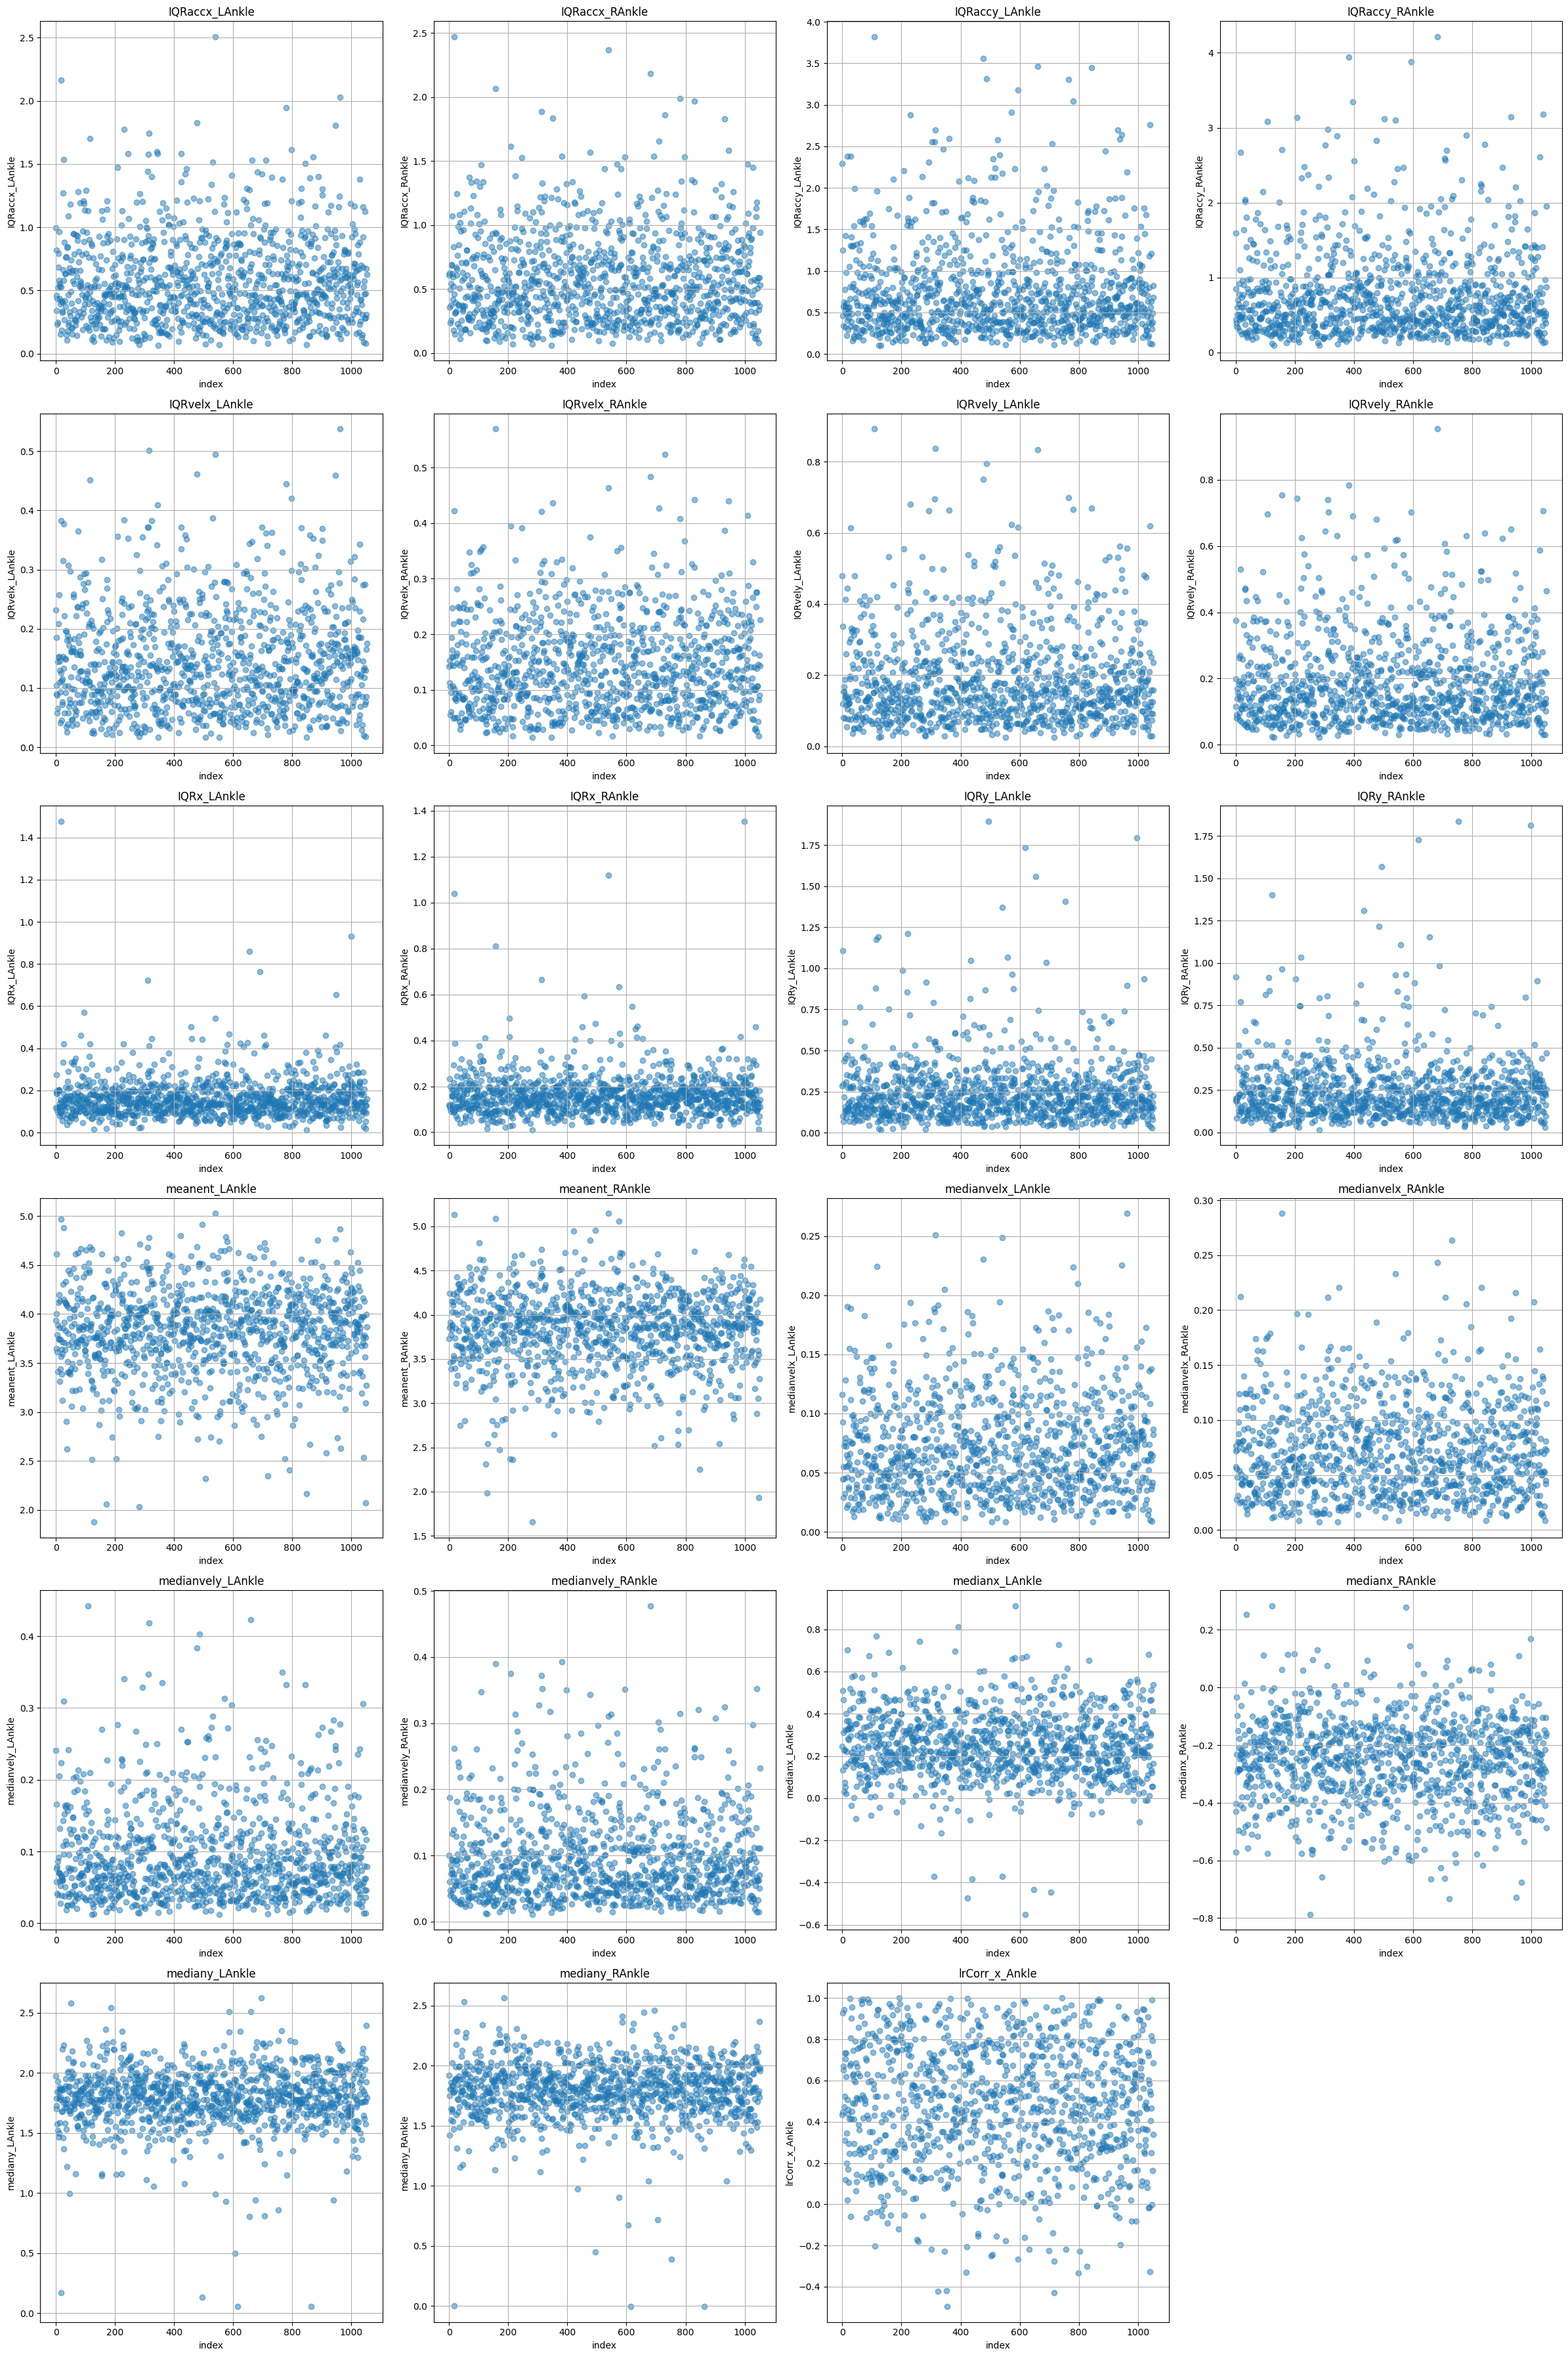

In [37]:
exclude_columns = ['video']
columns_to_plot = [col for col in features.columns if col not in exclude_columns]

bp = 'ankle'
columns = [col for col in columns_to_plot if bp in col.lower()]

# Create scatterplots
# Number of subplots
n_cols = 4  # Number of columns in the grid
n_rows = -(-len(columns) // n_cols)  # Ceiling division for the number of rows

# Create a figure and subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6 * n_rows), sharex=False, sharey=False)

# Flatten axes for easy iteration (if there's only one row, make sure it's iterable)
axes = axes.flatten()

# Plot each column in its subplot
for i, column in enumerate(columns):
    axes[i].scatter(features.index, features[column], alpha=0.5, label=column)
    axes[i].set_title(f'{column}')
    axes[i].set_xlabel('index')
    axes[i].set_ylabel(column)
    axes[i].grid(True)

# Remove empty subplots if there are any
for j in range(len(columns), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


In [43]:
os.makedirs(f'{pose_estimate_path}/window_features', exist_ok=True)

for csv in os.listdir(f'{pose_estimate_path}/xy_features/windows'):
    video_number = csv.split('_')[0]
    xy = pd.read_csv(f'{pose_estimate_path}/xy_features/windows/{csv}')   
    ang = pd.read_csv(f'{pose_estimate_path}/xy_features/windows/{csv}'.replace('xy','angle'))

    features = pd.merge(xy, ang, on=['video','frame'], how='inner').dropna()
    features.to_csv(f'{pose_estimate_path}/window_features/{csv}'.replace('xy','all'), header=True, index=False)

    del xy, ang, features

In [38]:
# Split features based on video file naming convention
if dataset == 'Youtube':
    features['infant'] = features['video'].str.split('_').str.get(1).str[-3:]
    features['session'] = features['video'].str.split('_').str.get(1).str[0]
    features['age'] = 'month'

elif dataset == 'Clinical':
    features['infant'] = features['video'].str.split('_').str.get(0).str[-1]
    features['session'] = features['video'].str.split('_').str.get(1).str[1]
    features['age'] = 'month'

elif dataset == 'gma_score_prediction':
    features['infant'] = features['video']
    features['session'] = 0
    features['age'] = '3_4_Month'

if SAVE:
    features.to_csv(f'{pose_estimate_path}/features.csv', header=True, index=False)

In [18]:
# Body parts and sides for features avearaged across whole video 
features = pd.read_csv('pose_estimates/gma_score_prediction_pose_estimates/features.csv')

body_parts = ["Knee", "Elbow", "Wrist", "Ankle"]
sides = ["L", "R"]

# Function to split the feature string into "feature", "part", and "side"
def split_feature(feature):
    # Split the feature into components
    parts = feature.split('_')
    feature_name = "_".join(parts[:-1])  # Default to everything before the last part
    part = parts[-1] if len(parts) > 1 else ""  # Default to the last part

    side = ""

    # Check if the last part has a side
    for body_part in body_parts:
        if body_part in part:  # Find body part
            idx = part.index(body_part)
            if idx > 0 and part[idx-1] in sides:  # Check for side prefix
                side = part[idx-1]
                part = part[idx:]  # Remove the side from the part
            break  # Exit loop after finding the body part

    # Adjust feature name to remove body part and side, if found
    if part in feature_name:
        feature_name = feature_name.replace(part, "").strip("_")
    if side in feature_name:
        feature_name = feature_name.replace(side, "").strip("_")

    return pd.Series([feature_name, part, side])

# Include data for the following, and restructure dataframe
# Customize for your specific dataset

id_vars = ['infant', 'age','session','video']
melted = pd.melt(features, id_vars=id_vars, var_name="feature", value_name="Value")

# Apply the function to the 'feature' column in your melted DataFrame
melted[['feature', 'part', 'side']] = melted['feature'].apply(split_feature)
melted = melted.dropna()

mean = melted.groupby(['infant', 'age', 'session', 'video', 'feature', 'part'])['Value'].mean().reset_index().drop(columns=['video'])
#Drop all rows with part not in body_parts (case insensitive)
mean = mean[mean['part'].isin(body_parts)]
mean.to_csv(f'{pose_estimate_path}/features_mean_by_side.csv', header=True, index=False)


mean.head()